In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')

In [3]:
from sklearn.datasets import fetch_california_housing

In [9]:
housing = fetch_california_housing()
data = pd.DataFrame(housing.data, columns=housing.feature_names)
data['Price'] = housing.target
print('Number of rows: ', data.shape[0])
print('Number of columns: ', data.shape[1])
data.head()

Number of rows:  20640
Number of columns:  9


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   Price       20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [16]:
from sklearn.model_selection import train_test_split

In [17]:
train_df, test_df = train_test_split(data, random_state=42, test_size=0.2)

In [18]:
train_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
14196,3.2596,33.0,5.017657,1.006421,2300.0,3.691814,32.71,-117.03,1.030
8267,3.8125,49.0,4.473545,1.041005,1314.0,1.738095,33.77,-118.16,3.821
17445,4.1563,4.0,5.645833,0.985119,915.0,2.723214,34.66,-120.48,1.726
14265,1.9425,36.0,4.002817,1.033803,1418.0,3.994366,32.69,-117.11,0.934
2271,3.5542,43.0,6.268421,1.134211,874.0,2.300000,36.78,-119.80,0.965


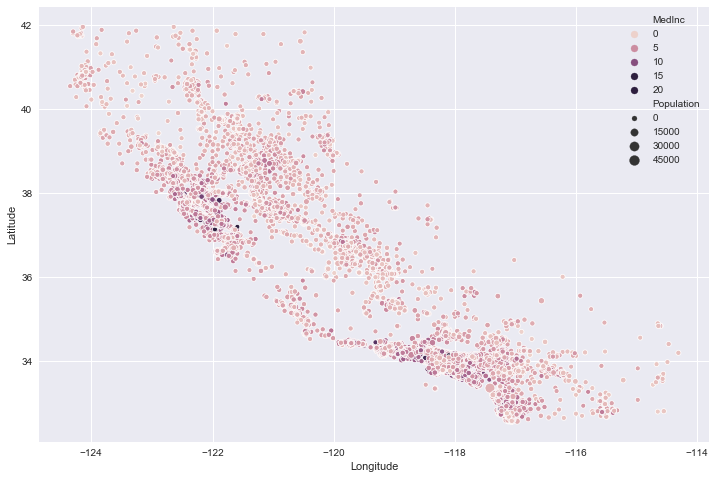

In [27]:
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(x='Longitude', y='Latitude', size='Population', 
                hue='MedInc', data=train_df, ax=ax)

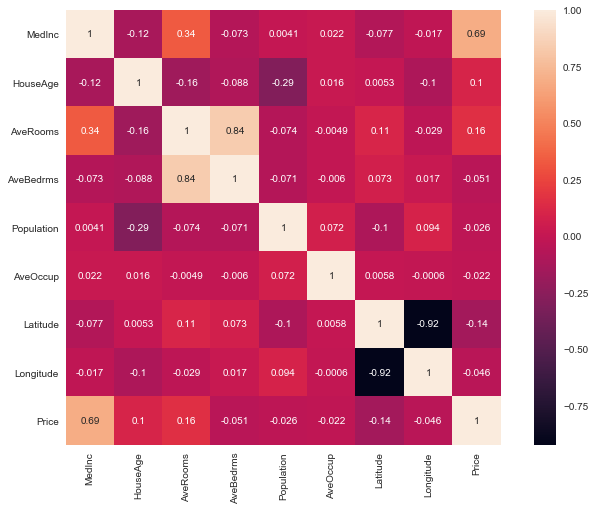

In [30]:
corr_mat = train_df.corr()
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(corr_mat, annot=True, square=True, ax=ax)

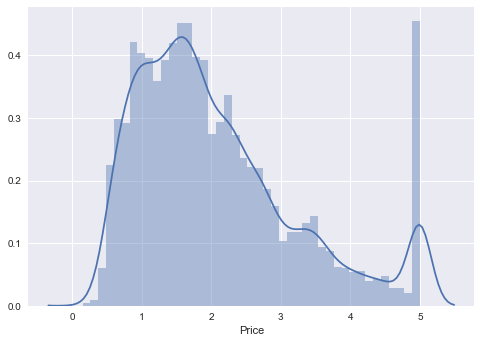

In [42]:
sns.distplot(train_df['Price'], hist=True);

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [47]:
X_train = train_df.drop(columns='Price')
Y_train = train_df['Price']

X_test = test_df.drop(columns='Price')
Y_test = test_df['Price']

imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train = imputer.fit_transform(X_train)
X_train = scaler.fit_transform(X_train)